In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
from typing import Optional
# import warnings
# warnings.filterwarnings("ignore")

# Функции и классы

In [2]:
from functools import reduce
from operator import matmul
from typing import Callable


def create_char_pol(*roots: complex) -> Callable[[np.ndarray], np.ndarray]:
    """
    Create characteristic polynomial from roots dynamically
    Return function that look like x -> (x - root[0]) @ (x - root[1]) @ ...
    (Subtraction is not element-wise, it's like in true math!)
    """
    dim = len(roots)

    char_pol = lambda x: (
        reduce(matmul, [x - np.identity(dim) * root for root in roots])
    )

    return char_pol

In [3]:
class PendODESystem:
    def __init__(
            self,
            pend_mass=0.127,
            cart_mass=1.206,
            moment_of_inertia=0.001,
            length=0.178,
            K_f=1.726,
            K_s=4.487,
            B_c=5.4,
            B_p=0.002,
    ) -> None:

        A_0 = np.array([
            [pend_mass + cart_mass, -pend_mass * length],
            [-pend_mass * length, moment_of_inertia + pend_mass * length * length]
        ])

        A_1 = np.array([
            [B_c, 0],
            [0, B_p]
        ])

        A_2 = np.array([
            [0, 0],
            [0, -pend_mass * 9.8 * length]
        ])

        first = -np.linalg.inv(A_0) @ A_2
        second = -np.linalg.inv(A_0) @ A_1
        third = np.linalg.inv(A_0) @ np.array([[1], [0]])

        self._A = np.array([
            [0, 0, 1, 0],
            [0, 0, 0, 1],
            [first[0][0], first[0][1], second[0][0], second[0][1]],
            [first[1][0], first[1][1], second[1][0], second[1][1]]
        ], dtype=np.complex_)

        self._b = np.array([
            [0],
            [0],
            third[0],
            third[1]
        ], dtype=np.complex_)

    @property
    def A(self):
        return self._A

    @property
    def b(self):
        return self._b

# Выполнение заданий

## Ситнез регулятора

In [4]:
pend = PendODESystem()

In [5]:
print(np.array_str(pend.A.astype(float), precision=3, suppress_small=True))

[[  0.      0.      1.      0.   ]
 [  0.      0.      0.      1.   ]
 [  0.      0.81   -4.386  -0.007]
 [  0.     47.74  -19.734  -0.431]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\4027671224.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(np.array_str(pend.A.astype(float), precision=3, suppress_small=True))


In [6]:
print(np.array_str(AAA, precision=3, suppress_small=True))

[[0.   ]
 [0.   ]
 [0.812]
 [3.655]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\3730716278.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(np.array_str(pend.b.astype(float), precision=3, suppress_small=True))


In [7]:
C = np.column_stack([
    pend.b,
    pend.A @ pend.b,
    np.linalg.matrix_power(pend.A, 2) @ pend.b,
    np.linalg.matrix_power(pend.A, 3) @ pend.b,
])

print(f"C = \n{np.array_str(C.astype(float), precision=3, suppress_small=True)}")
print(f"Shape: {C.shape}")
print(f"Rank: {np.linalg.matrix_rank(C)}")

C = 
[[    0.        0.812    -3.589    18.826]
 [    0.        3.655   -17.603   252.872]
 [    0.812    -3.589    18.826   -98.664]
 [    3.655   -17.603   252.872 -1320.853]]
Shape: (4, 4)
Rank: 4


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\782442745.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"C = \n{np.array_str(C.astype(float), precision=3, suppress_small=True)}")


In [8]:
print(f"Eigs: {np.array_str(np.linalg.eigvals(pend.A).astype(float), precision=3, suppress_small=True)}")

eigs = np.linalg.eigvals(pend.A)
eigs = list(map(float, eigs))

Eigs: [ 0.     6.598 -7.512 -3.902]


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\2514818238.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"Eigs: {np.array_str(np.linalg.eigvals(pend.A).astype(float), precision=3, suppress_small=True)}")
C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\2514818238.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs = list(map(float, eigs))


In [9]:
# перенесём 6.597 в устойчивое -6.597
theta_naive = (
    -np.array([[0, 0, 0, 1]])
    @ np.linalg.inv(C)
    @ create_char_pol(eigs[0], -eigs[1], eigs[2], eigs[3])(pend.A)
)

print(f"При переносе СЧ (6.597) в действительное (-6.597): theta = {theta_naive.astype(float)}\n")

# перенесём 0 и 6.597 в устойчивые -2.069 и -6.597
theta_real = (
    -np.array([[0, 0, 0, 1]])
    @ np.linalg.inv(C)
    @ create_char_pol(-2.069, -eigs[1], eigs[2], eigs[3])(pend.A)
)

print(f"При переносе СЧ (0, 6.597) в действительные (-2.069, -6.597): theta = {theta_real.astype(float)}\n")

# Перенесём СЧ 0 и 6.597 в пару комплексно сопряженных чисел -1-i, -1+i
theta_complex = (
    -np.array([[0, 0, 0, 1]])
    @ np.linalg.inv(C)
    @ create_char_pol(complex(-1, -1), complex(-1, 1), eigs[2], eigs[3])(pend.A)
)

print(f"При переносе СЧ (0, 6.597) пару комплексно сопряженных чисел (-1-i, -1+i): theta = {theta_complex.astype(float)}\n")


При переносе СЧ (6.597) в действительное (-6.597): theta = [[  0.         -42.16891715  10.8         -6.01083116]]

При переносе СЧ (0, 6.597) в действительные (-2.069, -6.597): theta = [[ 11.1726     -55.39297656  16.94482806  -7.94258352]]

При переносе СЧ (0, 6.597) пару комплексно сопряженных чисел (-1-i, -1+i): theta = [[  1.63695073 -28.44474067   7.68914687  -4.06141582]]



C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\783440184.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"При переносе СЧ (6.597) в действительное (-6.597): theta = {theta_naive.astype(float)}\n")
C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\783440184.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"При переносе СЧ (0, 6.597) в действительные (-2.069, -6.597): theta = {theta_real.astype(float)}\n")
C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\783440184.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"При переносе СЧ (0, 6.597) пару комплексно сопряженных чисел (-1-i, -1+i): theta = {theta_complex.astype(float)}\n")


In [10]:
print("Проверка СЧ полкченных после пременения управления:\n")

print(np.array_str(np.linalg.eigvals(pend.A + pend.b @ theta_naive).astype(float), precision=3))

print(np.array_str(np.linalg.eigvals(pend.A + pend.b @ theta_real).astype(float), precision=3))

print(np.array_str(np.linalg.eigvals(pend.A + pend.b @ theta_complex), precision=3, suppress_small=True))

Проверка СЧ полкченных после пременения управления:

[ 0.    -7.512 -6.598 -3.902]
[-7.512 -6.598 -2.069 -3.902]
[-7.512-0.j -3.902+0.j -1.   +1.j -1.   -1.j]


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\2718029753.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  print(np.array_str(np.linalg.eigvals(pend.A + pend.b @ theta_naive).astype(float), precision=3))
C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\2718029753.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  print(np.array_str(np.linalg.eigvals(pend.A + pend.b @ theta_real).astype(float), precision=3))


In [11]:
def linear_system(
        t: np.ndarray,
        x: np.ndarray,
        A: np.ndarray,
        b: np.ndarray,
        theta: np.ndarray,
        x_0: Optional[np.ndarray] = None
) -> np.ndarray:
    if x_0 is None:
        x_0 = x

    return A @ x + b @ theta @ x_0

In [12]:
start, stop = 0, 10

time = np.linspace(start, stop, 300)
y_0 = np.array([0, 0.1, 0, 0])

sol = integrate.solve_ivp(
    linear_system,
    (start, stop),
    y_0,
    dense_output=True,
    args=(pend.A, pend.b, theta_real),
    method="RK45"
)

C:\Users\Anton\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_ivp\base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


In [13]:
z = sol.sol(time)

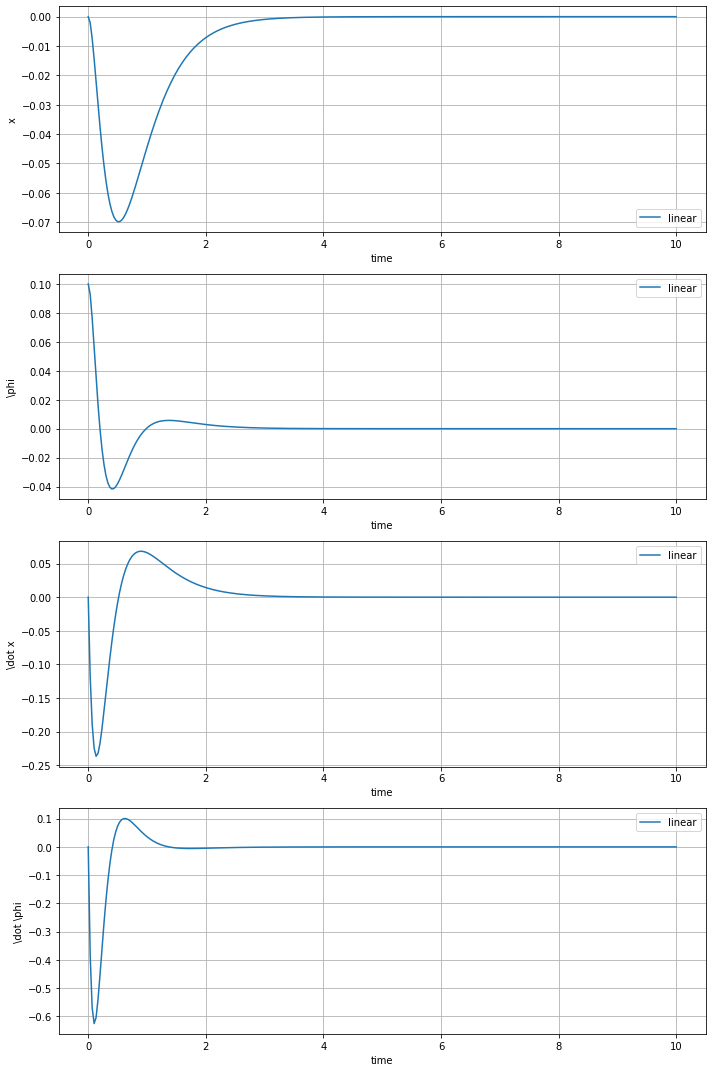

In [14]:
y_labels = (r"x", r"\phi", r"\dot x", r"\dot \phi")
# plt.rcParams['text.usetex'] = True # uncomment if you have latex

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(10, 15)

for i in range(4):
    axs[i].plot(time, z[i], label="linear")
    axs[i].set_xlabel('time')
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].legend()

fig.tight_layout()
# fig.savefig('out.png', dpi=300, facecolor='white') # uncomment to save high-res picture
plt.show()


## Синтез наблюдателя

In [36]:
pend.C = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0]])

In [69]:
eigs, eigs_vectors = np.linalg.eig(pend.A.T.astype(float))
p_inverse = np.vstack((eigs_vectors[0], 
                       eigs_vectors[1], 
                       [1, 0, 0, 0],
                       [0, 1, 0, 0]))

print(f"Rank: {np.linalg.matrix_rank(p_inverse)}")
print(np.array_str(p_inverse, precision=3, suppress_small=True))

Rank: 4
[[ 0.     0.     0.     0.971]
 [-0.96   0.74   0.092  0.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.     1.     0.     0.   ]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\3133056166.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs, eigs_vectors = np.linalg.eig(pend.A.T.astype(float))


In [70]:
p = np.linalg.inv(p_inverse)
A_hat = p_inverse @ pend.A.T.astype(float) @ p
c_hat = p_inverse @ pend.C.T

print(np.array_str(A_hat, precision=3, suppress_small=True))

print(np.array_str(c_hat, precision=3, suppress_small=True))

[[-0.431 -0.077 -0.074  1.028]
 [34.53   2.131  2.137 -1.577]
 [ 0.     0.     0.     0.   ]
 [49.174  8.804  8.448 -6.517]]
[[ 0.    0.  ]
 [-0.96  0.74]
 [ 1.    0.  ]
 [ 0.    1.  ]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\307208327.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  A_hat = p_inverse @ pend.A.T.astype(float) @ p


In [72]:
import sympy as sym

theta_1 = sym.Symbol('theta_1')
theta_2 = sym.Symbol('theta_2')

theta_for_L = np.array([[theta_1, theta_2, 0, 0],
                        [theta_1, theta_2, 0, 0]])

p_inverse @ (pend.A.T.astype(float) @ p - pend.C.T @ theta_for_L) 

#solution = sym.solve((x + 5 * y - 2, -3 * x + 6 * y - 15), (x, y))

[[-0.430988157970205 -0.0771612295365924 -0.07404604021439859
  1.027964928702655]
 [0.219416954876669*theta_1 + 34.529611538557
  0.219416954876669*theta_2 + 2.13093733630849 2.1368688167680476
  -1.5773423540896148]
 [-1.0*theta_1 -1.0*theta_2 0.0 0.0]
 [49.1737452953166 - 1.0*theta_1 8.80373759171397 - 1.0*theta_2
  8.448308971592027 -6.516619677684892]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_11488\2240790822.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  test = p_inverse @ (pend.A.T.astype(float) @ p - pend.C.T @ theta_for_L)


In [ ]:
C_observe = np.column_stack([pend.C.T,
                              pend.A.T @ pend.C.T,
                              np.linalg.matrix_power(pend.A.T, 2) @ pend.C.T,
                              np.linalg.matrix_power(pend.A.T, 3) @ pend.C.T,
                             ])

print(C_observe.astype(float))
print(C_observe.shape)
print(f"Rank: {np.linalg.matrix_rank(C_observe)}")

[[  1.           0.           0.           0.        ]
 [  1.           0.          48.54991498 -40.45238044]
 [  0.           1.         -24.12002548 114.43227666]
 [  0.           1.          -0.43829717  48.91510952]]
(4, 4)
Rank: 4


C:\Users\Anton\AppData\Local\Temp\ipykernel_15736\4119829214.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  print(C_observe.astype(float))


In [ ]:
print(f"Eigs: {np.linalg.eigvals(pend.A).astype(float)}")

eigs = np.linalg.eigvals(pend.A)
eigs = list(map(float, eigs))

Eigs: [ 0.          6.59763291 -7.51229932 -3.90200408]


C:\Users\Anton\AppData\Local\Temp\ipykernel_15736\3083912656.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"Eigs: {np.linalg.eigvals(pend.A).astype(float)}")
C:\Users\Anton\AppData\Local\Temp\ipykernel_15736\3083912656.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs = list(map(float, eigs))


In [ ]:
# Перенесём СЧ 0 и 6.597 в пару вещественных -2.069 и -6.597
L_real = -(-np.array([[0, 0, 0, 1]])
           @ np.linalg.inv(C_observe)
           @ create_char_pol(-2.069, -eigs[1], eigs[2], eigs[3])(pend.A.T)).T

print(f"При переносе СЧ в пару вещественных: L =\n {L_real.astype(float)}\n")

# Перенесём СЧ 0 и 6.597 в пару комплексно сопряженных чисел -1-i, -1+i
L_im = -(-np.array([[0, 0, 0, 1]])
         @ np.linalg.inv(C_observe)
         @ create_char_pol(complex(-1, -1), complex(-1, 1), eigs[2], eigs[3])(pend.A.T)).T

print(f"При переносе СЧ в пару комплексно сопряженных: L =\n {L_im.astype(float)}")



При переносе СЧ в пару вещественных: L =
 [[ -1.88876948]
 [ 17.1530353 ]
 [  1.18909479]
 [113.16943016]]

При переносе СЧ в пару комплексно сопряженных: L =
 [[-0.2105892 ]
 [ 8.80822211]
 [ 0.61060977]
 [58.11341603]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_15736\436024367.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"При переносе СЧ в пару вещественных: L =\n {L_real.astype(float)}\n")
C:\Users\Anton\AppData\Local\Temp\ipykernel_15736\436024367.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"При переносе СЧ в пару комплексно сопряженных: L =\n {L_im.astype(float)}")


### Перенос СЧ в действительные

In [ ]:
# TODO узнать является ли верхний правый блок нулевым 

A_observe_real = np.block([
    [pend.A,          pend.b @ theta_real],
    [L_real @ pend.C, pend.A - L_real @ pend.C + pend.b @ theta_real]
]).astype(float)

print(np.array_str(A_observe_real, precision=3, suppress_small=True))

[[   0.       0.       1.       0.       0.       0.       0.       0.   ]
 [   0.       0.       0.       1.       0.       0.       0.       0.   ]
 [   0.       0.81    -4.386   -0.007    9.074  -44.988   13.762   -6.451]
 [   0.      47.74   -19.734   -0.431   40.83  -202.434   61.925  -29.026]
 [  -1.889   -1.889    0.       0.       1.889    1.889    1.       0.   ]
 [  17.153   17.153    0.       0.     -17.153  -17.153    0.       1.   ]
 [   1.189    1.189    0.       0.      -1.189   -0.379   -4.386   -0.007]
 [ 113.169  113.169    0.       0.    -113.169  -65.429  -19.734   -0.431]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_15736\1781715206.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  A_observe_real = np.block([


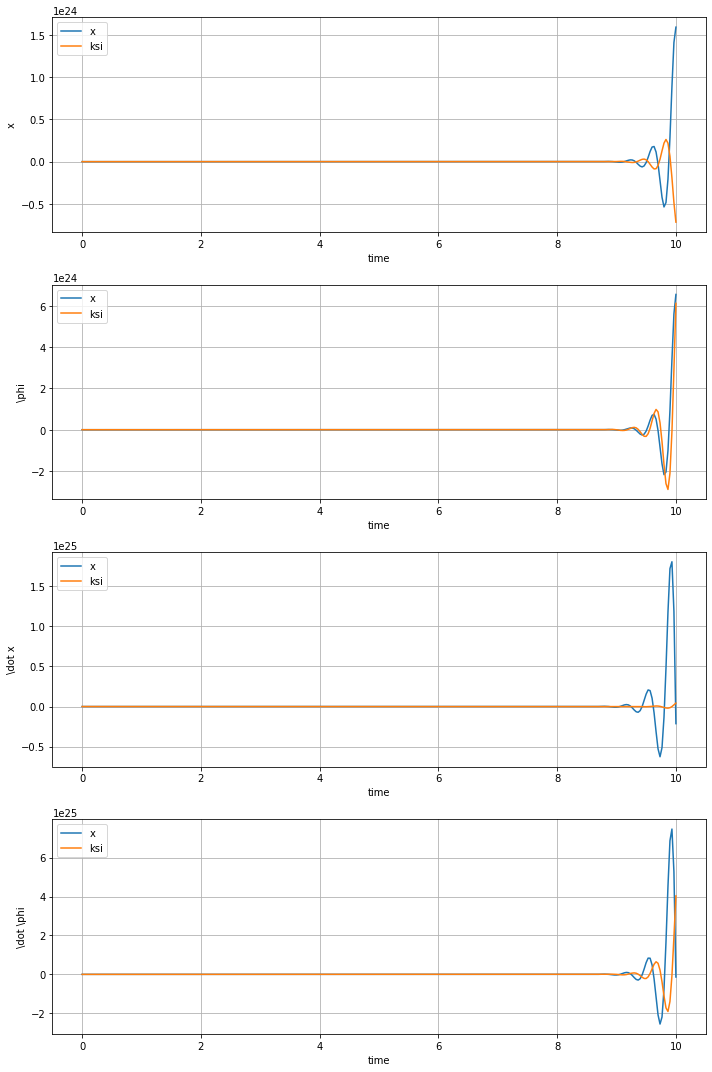

In [ ]:
def linear_system_observer_real(
        t: np.ndarray,
        x: np.ndarray,
        ) -> np.ndarray:
    
    return A_observe_real @ x 


start, stop = 0, 10

time = np.linspace(start, stop, 300)
y_0 = np.array([0, 0.1, 0, 0, 
                1, 0.1, 1, 0])

sol = integrate.solve_ivp(linear_system_observer_real,
                          (start, stop),
                          y_0,
                          dense_output=True,
                          args=(),
                          method="RK45")

z = sol.sol(time)

y_labels = (r"x", r"\phi", r"\dot x", r"\dot \phi")

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(10, 15)

for i in range(4):
    axs[i].plot(time, z[i], label="x")
    axs[i].plot(time, z[i + 4], label="ksi")
    axs[i].set_xlabel('time')
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].legend()

fig.tight_layout()
# fig.savefig('out.png', dpi=300, facecolor='white') # uncomment to save high-res picture
plt.show()


### Перенос СЧ в комплексные

In [ ]:
A_observe_im = np.block([
    [pend.A,        pend.b @ theta_complex],
    [L_im @ pend.C, pend.A - L_im @ pend.C + pend.b @ theta_complex]
]).astype(float)

print(np.array_str(A_observe_im, precision=3, suppress_small=True))

[[   0.       0.       1.       0.       0.       0.       0.       0.   ]
 [   0.       0.       0.       1.       0.       0.       0.       0.   ]
 [   0.       0.81    -4.386   -0.007    1.329  -23.102    6.245   -3.299]
 [   0.      47.74   -19.734   -0.431    5.982 -103.952   28.1    -14.842]
 [  -0.211   -0.211    0.       0.       0.211    0.211    1.       0.   ]
 [   8.808    8.808    0.       0.      -8.808   -8.808    0.       1.   ]
 [   0.611    0.611    0.       0.       0.719  -22.903    1.859   -3.306]
 [  58.113   58.113    0.       0.     -52.131 -114.325    8.366  -15.273]]


C:\Users\Anton\AppData\Local\Temp\ipykernel_15736\2632563011.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  A_observe_im = np.block([


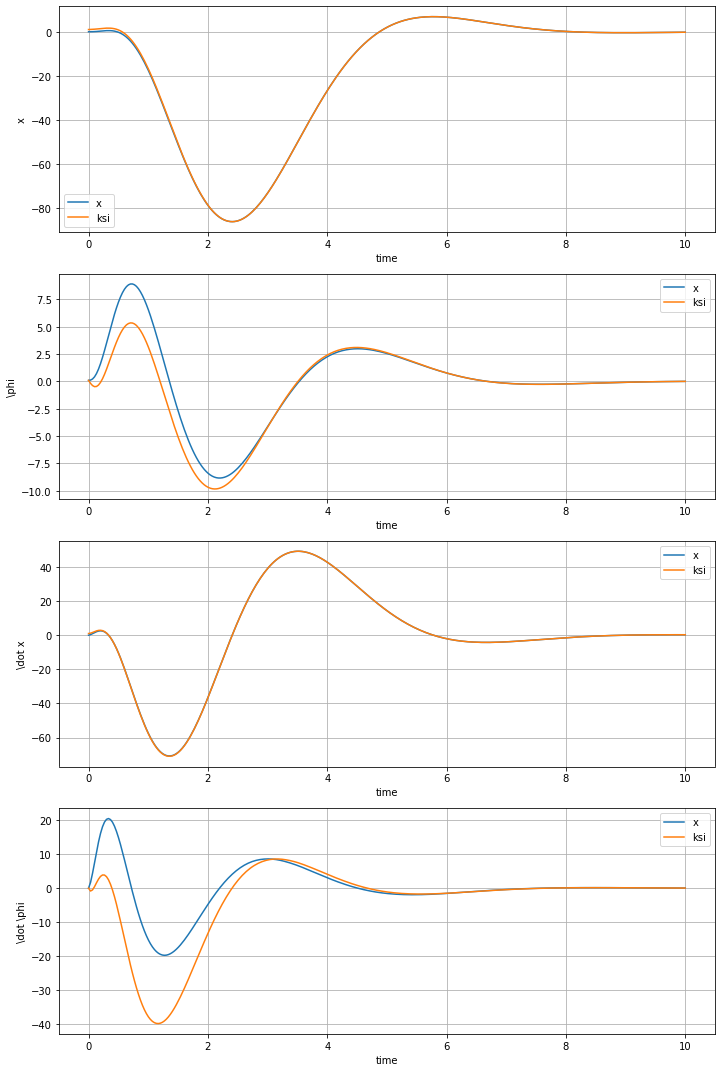

In [ ]:
def linear_system_observer_im(
        t: np.ndarray,
        x: np.ndarray,
        ) -> np.ndarray:
    
    return A_observe_im @ x 


start, stop = 0, 10

time = np.linspace(start, stop, 300)
y_0 = np.array([0, 0.1, 0, 0, 
                1, 0.1, 1, 0])

sol = integrate.solve_ivp(linear_system_observer_im,
                          (start, stop),
                          y_0,
                          dense_output=True,
                          args=(),
                          method="RK45")

z = sol.sol(time)

y_labels = (r"x", r"\phi", r"\dot x", r"\dot \phi")

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(10, 15)

for i in range(4):
    axs[i].plot(time, z[i], label="x")
    axs[i].plot(time, z[i + 4], label="ksi")
    axs[i].set_xlabel('time')
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].legend()

fig.tight_layout()
# fig.savefig('out.png', dpi=300, facecolor='white') # uncomment to save high-res picture
plt.show()
